In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import SubsetRandomSampler, DataLoader
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc

In [ ]:

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

X_train = trainset.data.reshape(len(trainset), -1)
X_test = testset.data.reshape(len(testset), -1)

train_mask = torch.tensor([(target == 5 or target == 3) for target in trainset.targets], dtype=torch.bool)
test_mask = torch.tensor([(target == 5 or target == 3) for target in testset.targets], dtype=torch.bool)

trainset.data = trainset.data[train_mask]
trainset.targets = torch.tensor(trainset.targets)[train_mask]
testset.data = testset.data[test_mask]
testset.targets = torch.tensor(testset.targets)[test_mask]

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainset.targets = torch.tensor([1 if target == 5 else 0 for target in trainset.targets])
testset.targets = torch.tensor([1 if target == 5 else 0 for target in testset.targets])

In [ ]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])
print(len(train_dataset), len(val_dataset), len(testset))

8000 2000 2000


Label
0    5000
1    5000
Name: count, dtype: int64


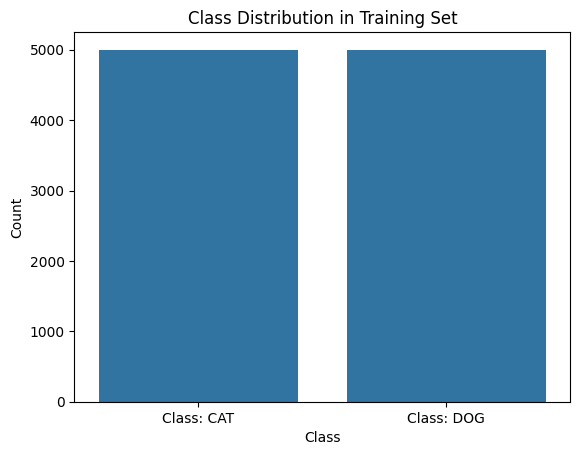

In [ ]:
import pandas as pd
import seaborn as sns

y_train = trainset.targets

df = pd.DataFrame({'Label': y_train})
print(df['Label'].value_counts())
sns.countplot(data=df, x='Label')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Class: CAT', 'Class: DOG'])
plt.show()


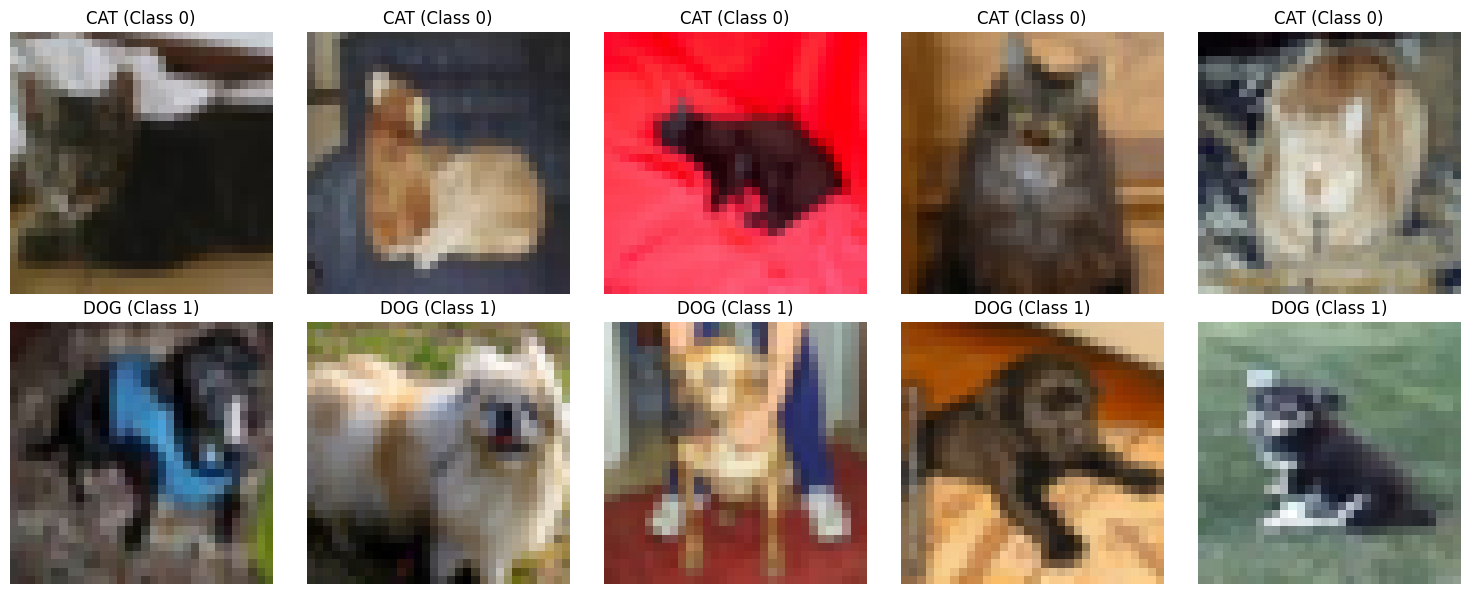

In [ ]:
def plot_sample_images(dataset, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    cat_idx = np.where(dataset.targets == 0)[0][:num_samples]
    dog_idx = np.where(dataset.targets == 1)[0][:num_samples]

    for i in range(num_samples):
        axes[0, i].imshow(dataset.data[cat_idx[i]])
        axes[0, i].set_title('CAT (Class 0)')
        axes[0, i].axis('off')

        axes[1, i].imshow(dataset.data[dog_idx[i]])
        axes[1, i].set_title('DOG (Class 1)')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(trainset)

In [ ]:
validation_split = 0.2
dataset_size = len(trainset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

batch_size = 128
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(testset, batch_size=batch_size)

In [ ]:
def extract_data(train_loader, val_loader):
    X_train, y_train = [], []
    for data, target in train_loader:
        X_train.append(data.numpy().reshape(data.shape[0], -1))
        y_train.append(target.numpy())
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_val, y_val = [], []
    for data, target in val_loader:
        X_val.append(data.numpy().reshape(data.shape[0], -1))
        y_val.append(target.numpy())
    X_val = np.concatenate(X_val)
    y_val = np.concatenate(y_val)

    return X_train, y_train, X_val, y_val

In [ ]:
class PCAFNN(nn.Module):
    def __init__(self, input_size=256, hidden_sizes=[192, 96], output_size=2, dropout_base=0.1, use_sigmoid=True):
        super(PCAFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.dropout1 = nn.Dropout(dropout_base)
        self.dropout2 = nn.Dropout(dropout_base * 0.8)
        self.use_sigmoid = use_sigmoid

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))  #
        x = self.dropout1(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        if self.use_sigmoid:
            x = torch.sigmoid(x)
        return x


In [ ]:
X_train, y_train, X_val, y_val = extract_data(train_loader, valid_loader)

pca = PCA(n_components=256)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

X_train_tensor = torch.FloatTensor(X_train_pca)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_pca)
y_val_tensor = torch.LongTensor(y_val)


model = PCAFNN(input_size=256)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

X_train_tensor = X_train_tensor
y_train_tensor = y_train_tensor
X_val_tensor = X_val_tensor
y_val_tensor = y_val_tensor

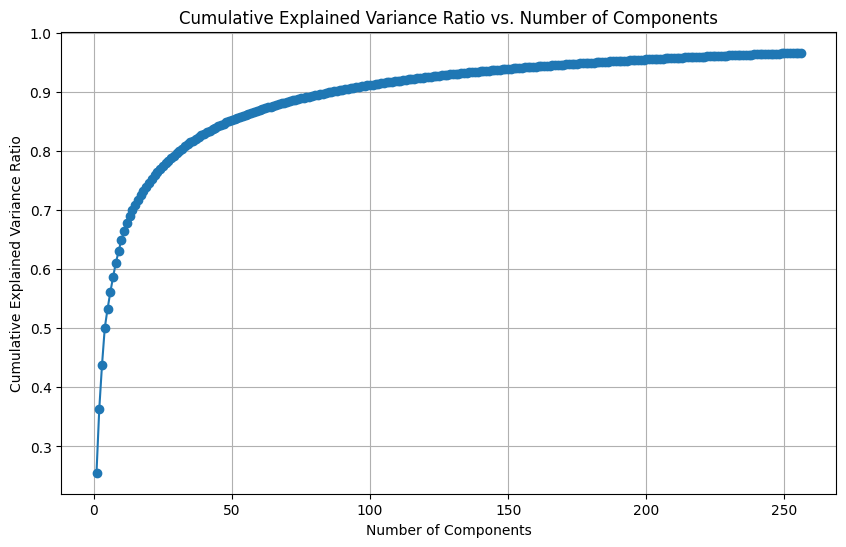

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

Epoch 1/100
    Training Loss: 0.6944, Training Accuracy: 49.96%
    Validation Loss: 0.6936, Validation Accuracy: 50.30%
Epoch 2/100
    Training Loss: 0.6944, Training Accuracy: 50.71%
    Validation Loss: 0.6936, Validation Accuracy: 50.20%
Epoch 3/100
    Training Loss: 0.6940, Training Accuracy: 50.32%
    Validation Loss: 0.6936, Validation Accuracy: 50.20%
Epoch 4/100
    Training Loss: 0.6944, Training Accuracy: 50.21%
    Validation Loss: 0.6936, Validation Accuracy: 50.30%
Epoch 5/100
    Training Loss: 0.6938, Training Accuracy: 50.44%
    Validation Loss: 0.6936, Validation Accuracy: 50.25%
Epoch 6/100
    Training Loss: 0.6947, Training Accuracy: 50.55%
    Validation Loss: 0.6936, Validation Accuracy: 50.30%
Epoch 7/100
    Training Loss: 0.6946, Training Accuracy: 49.95%
    Validation Loss: 0.6936, Validation Accuracy: 50.35%
Epoch 8/100
    Training Loss: 0.6944, Training Accuracy: 50.35%
    Validation Loss: 0.6936, Validation Accuracy: 50.25%
Epoch 9/100
    Training

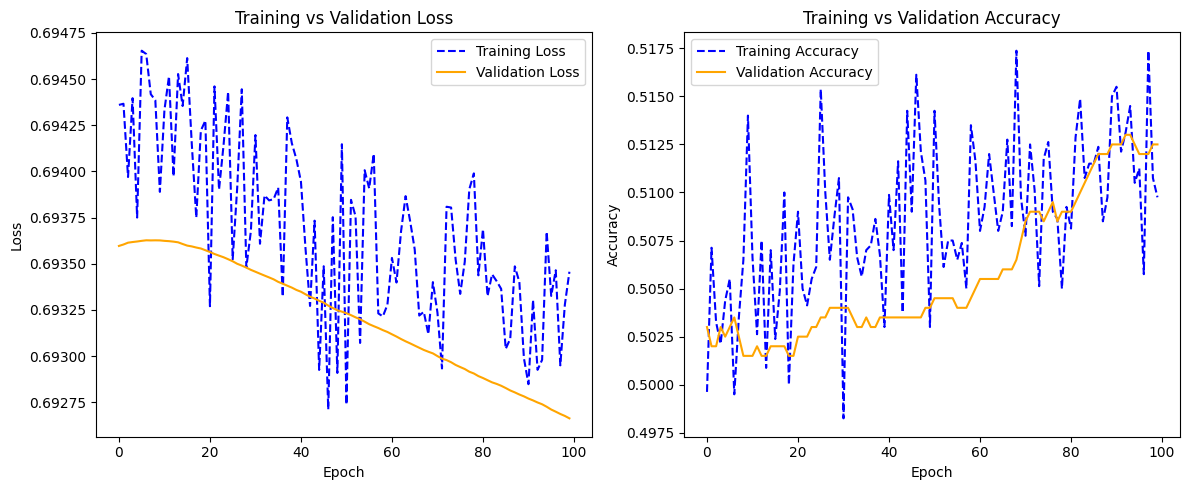

In [ ]:
import matplotlib.pyplot as plt

epochs = 100

training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs_train = model(X_train_tensor)
    loss_train = criterion(outputs_train, y_train_tensor)
    loss_train.backward()
    optimizer.step()

    _, predicted_train = torch.max(outputs_train.data, 1)
    accuracy_train = (predicted_train == y_train_tensor).sum().item() / len(y_train_tensor)

    model.eval()
    with torch.no_grad():
        outputs_val = model(X_val_tensor)
        loss_val = criterion(outputs_val, y_val_tensor)
        _, predicted_val = torch.max(outputs_val.data, 1)
        accuracy_val = (predicted_val == y_val_tensor).sum().item() / len(y_val_tensor)

    training_losses.append(loss_train.item())
    training_accuracies.append(accuracy_train)
    validation_losses.append(loss_val.item())
    validation_accuracies.append(accuracy_val)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"    Training Loss: {loss_train.item():.4f}, Training Accuracy: {accuracy_train * 100:.2f}%")
    print(f"    Validation Loss: {loss_val.item():.4f}, Validation Accuracy: {accuracy_val * 100:.2f}%")

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss', color='blue', linestyle='--')
plt.plot(validation_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy', color='blue', linestyle='--')
plt.plot(validation_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


ROC AUC Score: 0.5269034304548873


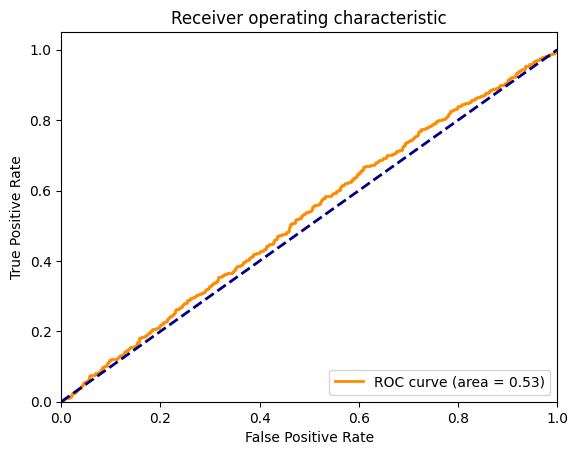

In [ ]:

with torch.no_grad():
    model.eval()
    outputs_val = model(X_val_tensor)
    probabilities = torch.softmax(outputs_val, dim=1)[:, 1].numpy()


roc_auc = roc_auc_score(y_val_tensor, probabilities)
print(f"ROC AUC Score: {roc_auc}")


fpr, tpr, thresholds = roc_curve(y_val_tensor, probabilities)
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    probabilities = torch.softmax(val_outputs, dim=1)[:, 1].numpy()
    _, predicted = torch.max(val_outputs.data, 1)


    accuracy = accuracy_score(y_val_tensor, predicted)
    auroc = roc_auc_score(y_val_tensor, probabilities)


    cat_accuracy = accuracy_score(y_val_tensor[y_val_tensor == 0],
                                predicted[y_val_tensor == 0])
    dog_accuracy = accuracy_score(y_val_tensor[y_val_tensor == 1],
                            predicted[y_val_tensor == 1])

print("\nFinal Validation Results:\n=========================")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"\nAUROC Score: {auroc:.4f}")
print(f"\nCat (Class 0) Accuracy: {cat_accuracy:.4f}")
print(f"\nDog (Class 1) Accuracy: {dog_accuracy:.4f}")


Final Validation Results:
Overall Accuracy: 0.5125

AUROC Score: 0.5269

Cat (Class 0) Accuracy: 0.7641

Dog (Class 1) Accuracy: 0.2629


HYPERPARAMETER TUNING

In [ ]:
import random
from itertools import product
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA

def randomized_search_pca_fnn(X_train, y_train, X_val, y_val, n_trials=50):

    param_space = {
        'n_components': [256, 384, 512],
        'learning_rate': [0.01, 0.005, 0.001, 0.0005, 0.0001],
        'batch_size': [16, 32, 64, 128],
        'dropout_base': [0.3, 0.4, 0.5],
        'optimizer': ['Adam', 'SGD', 'RMSprop'],
        'epochs': [50, 100, 200, 250]
    }

    all_combinations = list(product(*param_space.values()))
    sampled_combinations = random.sample(all_combinations, n_trials)
    param_names = list(param_space.keys())

    best_val_accuracy = 0
    best_hyperparameters = None

    print(f"Total trials to evaluate: {n_trials}")

    for trial_idx, values in enumerate(sampled_combinations):
        current_params = dict(zip(param_names, values))
        print(f"\nTrial {trial_idx + 1}/{n_trials}: Testing with parameters: {current_params}")

        pca = PCA(n_components=current_params['n_components'])
        X_train_pca = pca.fit_transform(X_train)
        X_val_pca = pca.transform(X_val)

        X_train_tensor = torch.FloatTensor(X_train_pca)
        y_train_tensor = torch.LongTensor(y_train)
        X_val_tensor = torch.FloatTensor(X_val_pca)
        y_val_tensor = torch.LongTensor(y_val)

        model = PCAFNN(
            input_size=current_params['n_components'],
            dropout_base=current_params['dropout_base']
        )

        criterion = nn.CrossEntropyLoss()

        if current_params['optimizer'] == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=current_params['learning_rate'])
        elif current_params['optimizer'] == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=current_params['learning_rate'])
        elif current_params['optimizer'] == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=current_params['learning_rate'])

        n_samples = len(X_train_tensor)
        for epoch in range(current_params['epochs']):
            model.train()
            for i in range(0, n_samples, current_params['batch_size']):
                batch_x = X_train_tensor[i:i + current_params['batch_size']]
                batch_y = y_train_tensor[i:i + current_params['batch_size']]

                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            _, predicted = torch.max(val_outputs.data, 1)
            val_accuracy = (predicted == y_val_tensor).sum().item() / len(y_val_tensor)

        print(f"    Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_hyperparameters = current_params
            print(f"    New best model found!")

    print("\nBest Model Parameters:")
    print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
    for param, value in best_hyperparameters.items():
        print(f"{param}: {value}")

    return best_hyperparameters

best_hyperparameters = randomized_search_pca_fnn(X_train, y_train, X_val, y_val, n_trials=50)


Total trials to evaluate: 50

Trial 1/50: Testing with parameters: {'n_components': 384, 'learning_rate': 0.0005, 'batch_size': 16, 'dropout_base': 0.5, 'optimizer': 'SGD', 'epochs': 250}
    Validation Accuracy: 0.6340
    New best model found!

Trial 2/50: Testing with parameters: {'n_components': 384, 'learning_rate': 0.0001, 'batch_size': 128, 'dropout_base': 0.3, 'optimizer': 'RMSprop', 'epochs': 50}
    Validation Accuracy: 0.6275

Trial 3/50: Testing with parameters: {'n_components': 384, 'learning_rate': 0.0005, 'batch_size': 32, 'dropout_base': 0.3, 'optimizer': 'RMSprop', 'epochs': 200}
    Validation Accuracy: 0.6315

Trial 4/50: Testing with parameters: {'n_components': 256, 'learning_rate': 0.0001, 'batch_size': 64, 'dropout_base': 0.5, 'optimizer': 'SGD', 'epochs': 200}
    Validation Accuracy: 0.5685

Trial 5/50: Testing with parameters: {'n_components': 384, 'learning_rate': 0.005, 'batch_size': 64, 'dropout_base': 0.5, 'optimizer': 'Adam', 'epochs': 200}
    Validation

In [94]:
import torch
from torch import nn, optim

class OptimizedPCAFNN(nn.Module):
    def __init__(self, input_size, dropout_rate):
        super(OptimizedPCAFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

input_dim = 256
dropout_rate = 0.4
best_learning_rate = 0.001
best_batch_size = 32
best_epochs = 100
best_weight_decay = 0.001

final_model = OptimizedPCAFNN(input_size=input_dim, dropout_rate=dropout_rate)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)

num_samples = len(X_train_tensor)
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(best_epochs):
    final_model.train()
    for i in range(0, num_samples, best_batch_size):
        batch_inputs = X_train_tensor[i:i + best_batch_size]
        batch_labels = y_train_tensor[i:i + best_batch_size]

        optimizer.zero_grad()
        predictions = final_model(batch_inputs)
        loss = loss_function(predictions, batch_labels)
        loss.backward()
        optimizer.step()

    final_model.eval()
    with torch.no_grad():
        train_outputs = final_model(X_train_tensor)
        train_loss = loss_function(train_outputs, y_train_tensor)
        _, train_predictions = torch.max(train_outputs, 1)
        train_accuracy = (train_predictions == y_train_tensor).sum().item() / len(y_train_tensor)

        val_outputs = final_model(X_val_tensor)
        val_loss = loss_function(val_outputs, y_val_tensor)
        _, val_predictions = torch.max(val_outputs, 1)
        val_accuracy = (val_predictions == y_val_tensor).sum().item() / len(y_val_tensor)

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

    if epoch % 10 == 0 or epoch == best_epochs - 1:
        print(f'\nEpoch [{epoch + 1}/{best_epochs}]')
        print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

print("\nTraining Complete.")
print(f"Best Validation Accuracy Achieved: {max(val_accuracies):.4f}")



Epoch [1/100]
Training Loss: 0.6419, Training Accuracy: 0.6432
Validation Loss: 0.6625, Validation Accuracy: 0.6090

Epoch [11/100]
Training Loss: 0.4095, Training Accuracy: 0.8363
Validation Loss: 0.6589, Validation Accuracy: 0.6375

Epoch [21/100]
Training Loss: 0.2583, Training Accuracy: 0.9173
Validation Loss: 0.7248, Validation Accuracy: 0.6385

Epoch [31/100]
Training Loss: 0.1772, Training Accuracy: 0.9525
Validation Loss: 0.8167, Validation Accuracy: 0.6365

Epoch [41/100]
Training Loss: 0.1379, Training Accuracy: 0.9674
Validation Loss: 0.8768, Validation Accuracy: 0.6420

Epoch [51/100]
Training Loss: 0.1001, Training Accuracy: 0.9791
Validation Loss: 0.9239, Validation Accuracy: 0.6335

Epoch [61/100]
Training Loss: 0.0814, Training Accuracy: 0.9896
Validation Loss: 0.9091, Validation Accuracy: 0.6400

Epoch [71/100]
Training Loss: 0.0687, Training Accuracy: 0.9908
Validation Loss: 0.9326, Validation Accuracy: 0.6455

Epoch [81/100]
Training Loss: 0.0678, Training Accuracy:

In [95]:
import numpy as np
import torch
from sklearn.metrics import roc_auc_score

X_test, y_test = [], []
for data, target in test_loader:
    X_test.append(data.numpy().reshape(data.shape[0], -1))
    y_test.append(target.numpy())
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

X_test_pca = pca.transform(X_test)
X_test_tensor = torch.FloatTensor(X_test_pca)
y_test_tensor = torch.LongTensor(y_test)

final_model.eval()
with torch.no_grad():

    test_outputs = final_model(X_test_tensor)
    probabilities = torch.softmax(test_outputs, dim=1)[:, 1].numpy()
    _, predicted = torch.max(test_outputs.data, 1)

    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    auroc = roc_auc_score(y_test_tensor, probabilities)

    cat_mask = y_test_tensor == 0
    dog_mask = y_test_tensor == 1
    cat_acc = (predicted[cat_mask] == y_test_tensor[cat_mask]).sum().item() / cat_mask.sum()
    dog_acc = (predicted[dog_mask] == y_test_tensor[dog_mask]).sum().item() / dog_mask.sum()

print("\nFinal Test Set Results:")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"AUROC Score: {auroc:.4f}")
print(f"Cat (Class 0) Accuracy: {cat_acc:.4f}")
print(f"Dog (Class 1) Accuracy: {dog_acc:.4f}")



Final Test Set Results:
Overall Accuracy: 0.6370
AUROC Score: 0.6839
Cat (Class 0) Accuracy: 0.6390
Dog (Class 1) Accuracy: 0.6350


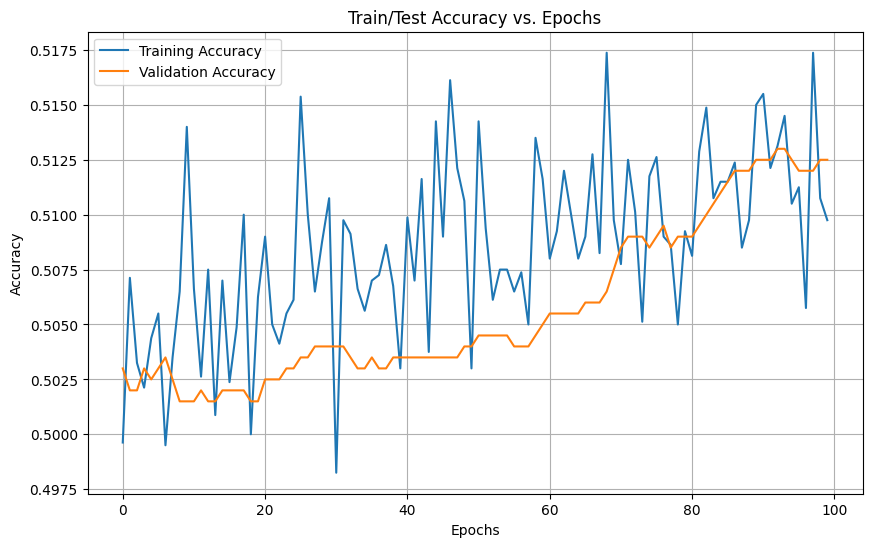

In [96]:

plt.figure(figsize=(10, 6))
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train/Test Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


Training Complete.
Best Validation Accuracy Achieved: 0.6635
Train AUROC: 0.9900, Validation AUROC: 0.6882
Train Per-Class Accuracy: [1.005994005994006, 0.993993993993994]
Validation Per-Class Accuracy: [1.0301204819277108, 0.9701195219123506]


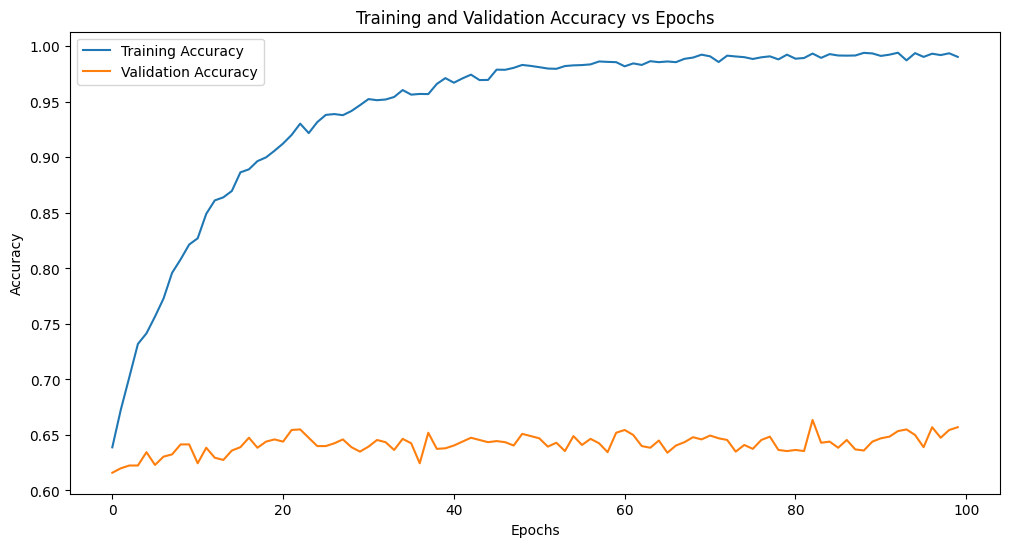

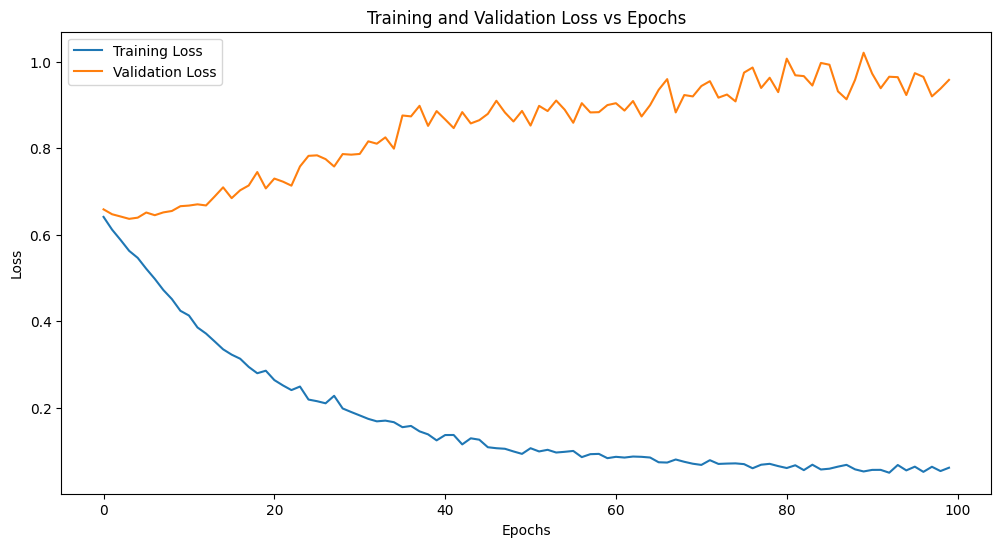

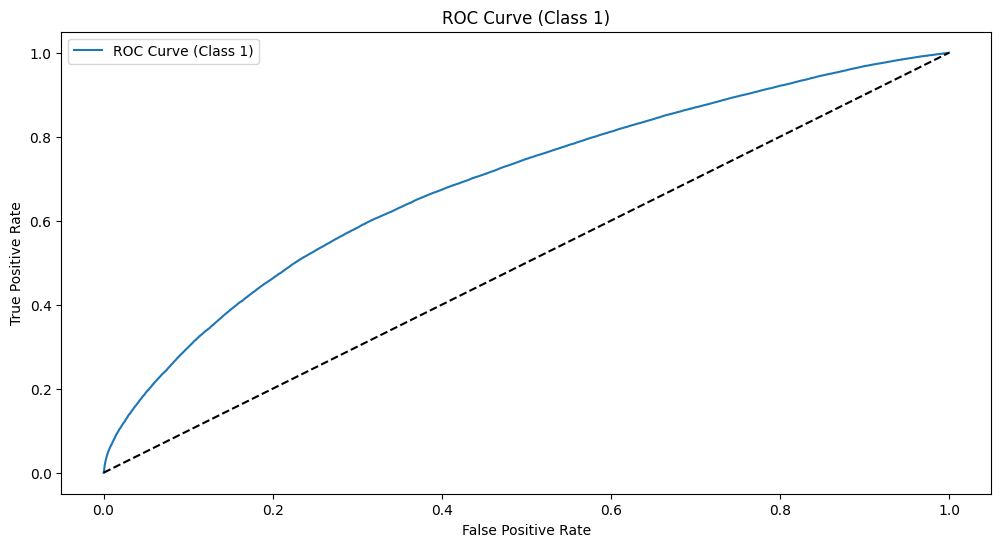

In [102]:
train_auroc = roc_auc_score(train_labels, train_probs[:, 1])
val_auroc = roc_auc_score(val_labels, val_probs[:, 1])

train_per_class_accuracy = [(train_predictions == i).sum().item() / (y_train_tensor == i).sum().item() for i in range(2)]
val_per_class_accuracy = [(val_predictions == i).sum().item() / (y_val_tensor == i).sum().item() for i in range(2)]

print("\nTraining Complete.")
print(f"Best Validation Accuracy Achieved: {max(val_accuracies):.4f}")
print(f"Train AUROC: {train_auroc:.4f}, Validation AUROC: {val_auroc:.4f}")
print("Train Per-Class Accuracy:", train_per_class_accuracy)
print("Validation Per-Class Accuracy:", val_per_class_accuracy)

plt.figure(figsize=(12, 6))
plt.plot(range(best_epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(best_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(best_epochs), train_losses, label='Training Loss')
plt.plot(range(best_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.legend()
plt.show()

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(val_labels, val_probs[:, 1])
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, label='ROC Curve (Class 1)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Class 1)')
plt.legend()
plt.show()



Dropout Rate: 0.1
Best Validation Accuracy: 0.6350
Test Accuracy: 0.6400

Dropout Rate: 0.2
Best Validation Accuracy: 0.6500
Test Accuracy: 0.6085

Dropout Rate: 0.3
Best Validation Accuracy: 0.6620
Test Accuracy: 0.6370

Dropout Rate: 0.4
Best Validation Accuracy: 0.6525
Test Accuracy: 0.6330

Dropout Rate: 0.5
Best Validation Accuracy: 0.6580
Test Accuracy: 0.6355


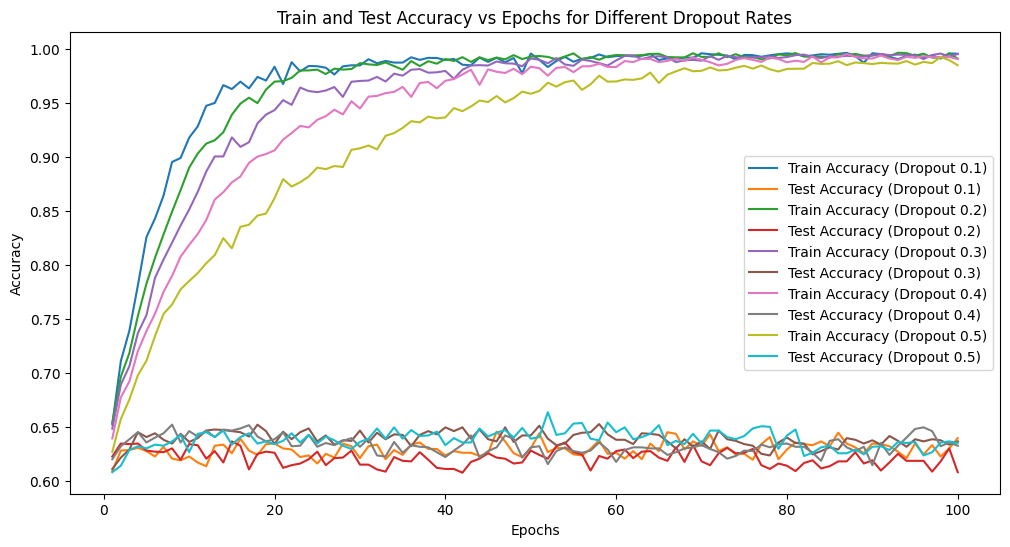

In [106]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

# Define the model
class OptimizedPCAFNN(nn.Module):
    def __init__(self, input_size, dropout_rate):
        super(OptimizedPCAFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Hyperparameter setup
input_dim = 256
best_learning_rate = 0.001
best_batch_size = 32
best_epochs = 100
best_weight_decay = 0.001

dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
train_accuracies_list, val_accuracies_list, test_accuracies_list = [], [], []

for dropout_rate in dropout_rates:

    final_model = OptimizedPCAFNN(input_size=input_dim, dropout_rate=dropout_rate)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(final_model.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)

    train_accuracies, val_accuracies, test_accuracies = [], [], []

    for epoch in range(best_epochs):
        final_model.train()
        for i in range(0, len(X_train_tensor), best_batch_size):
            batch_inputs = X_train_tensor[i:i + best_batch_size]
            batch_labels = y_train_tensor[i:i + best_batch_size]

            optimizer.zero_grad()
            predictions = final_model(batch_inputs)
            loss = loss_function(predictions, batch_labels)
            loss.backward()
            optimizer.step()

        final_model.eval()
        with torch.no_grad():
            train_outputs = final_model(X_train_tensor)
            _, train_predictions = torch.max(train_outputs, 1)
            train_accuracy = (train_predictions == y_train_tensor).sum().item() / len(y_train_tensor)

            val_outputs = final_model(X_val_tensor)
            _, val_predictions = torch.max(val_outputs, 1)
            val_accuracy = (val_predictions == y_val_tensor).sum().item() / len(y_val_tensor)

            test_outputs = final_model(X_test_tensor)
            _, test_predictions = torch.max(test_outputs, 1)
            test_accuracy = (test_predictions == y_test_tensor).sum().item() / len(y_test_tensor)

            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            test_accuracies.append(test_accuracy)

    train_accuracies_list.append(train_accuracies)
    val_accuracies_list.append(val_accuracies)
    test_accuracies_list.append(test_accuracies)

    print(f'\nDropout Rate: {dropout_rate}')
    print(f'Best Validation Accuracy: {max(val_accuracies):.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

plt.figure(figsize=(12, 6))

for i, dropout_rate in enumerate(dropout_rates):
    plt.plot(range(1, best_epochs + 1), train_accuracies_list[i], label=f'Train Accuracy (Dropout {dropout_rate})')
    plt.plot(range(1, best_epochs + 1), test_accuracies_list[i], label=f'Test Accuracy (Dropout {dropout_rate})')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy vs Epochs for Different Dropout Rates')
plt.legend()
plt.show()
